# Лабораторная работа №3. Использование механизмов внимания в нейронных сетях

Выполнил Сердюков Матвей, ББМО-01-23

## Загрузка модели VGG16, переключение активации `softmax` на линейную

In [1]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.


2024-12-09 18:20:19.668887: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-12-09 18:20:19.675454: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2592000000 Hz
2024-12-09 18:20:19.676617: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56495e59bc20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-12-09 18:20:19.676650: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-12-09 18:20:19.679350: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


2024-12-09 18:20:20.001157: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:969] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-09 18:20:20.001316: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56495e63b8d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 18:20:20.001333: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-09 18:20:20.002958: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:969] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-09 18:20:20.003011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3060 major: 8 minor: 6 memoryClockRate(GHz): 1.807
pciBusID

## Загрузка изображений

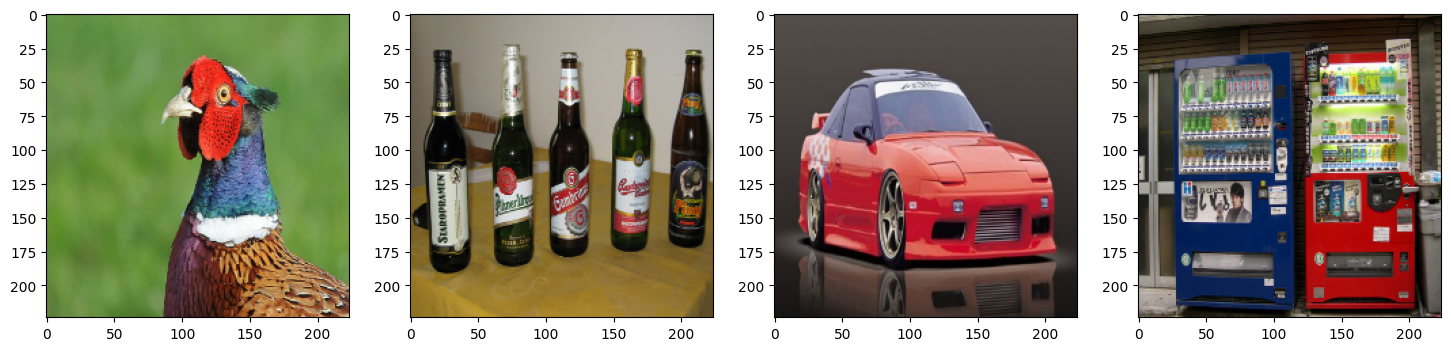

In [42]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

INDICES = [7, 440, 817, 886]

img1 = utils.load_img('./images/n01514668_cock.JPEG', target_size=(224, 224))
img2 = utils.load_img('./images/n02823428_beer_bottle.JPEG', target_size=(224, 224))
img3 = utils.load_img('./images/n04285008_sports_car.JPEG', target_size=(224, 224))
img4 = utils.load_img('./images/n04525305_vending_machine.JPEG', target_size=(224, 224))

f, ax = plt.subplots(1, 4)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)
ax[3].imshow(img4)

## Карты значимости признаков

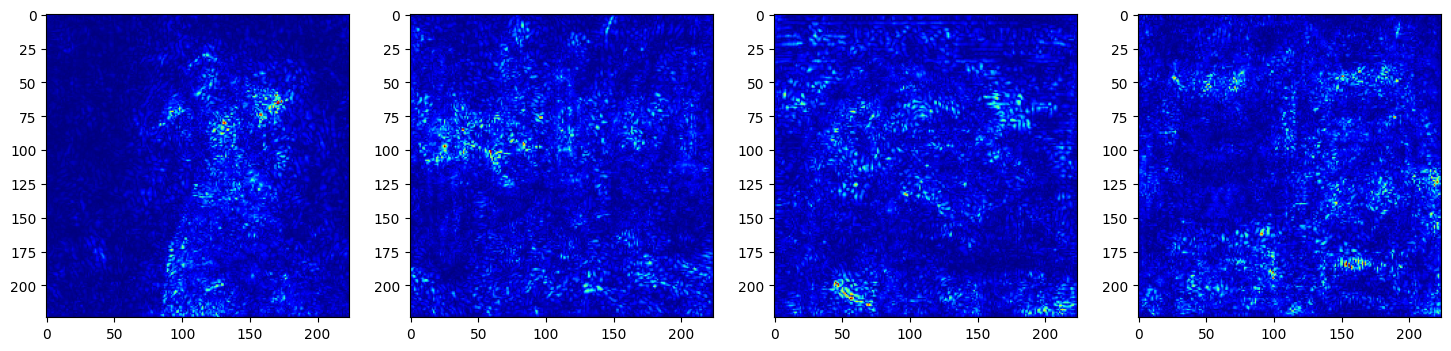

In [44]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

f, ax = plt.subplots(1, 4)
for i, img in enumerate([img1, img2, img3, img4]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=INDICES[i], seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')

## Отображение признаков с применением управляемой значимости и устранения деконверсии

<Figure size 1800x600 with 0 Axes>

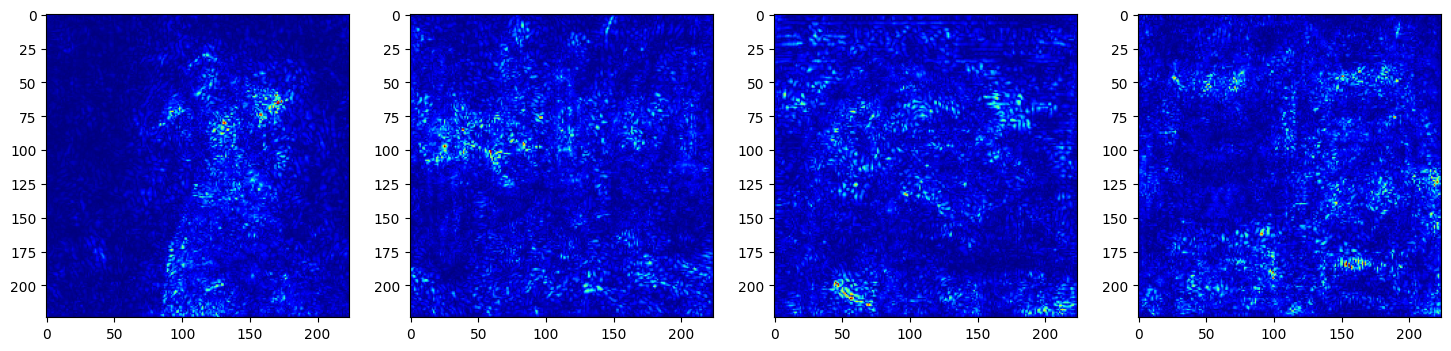

<Figure size 1800x600 with 0 Axes>

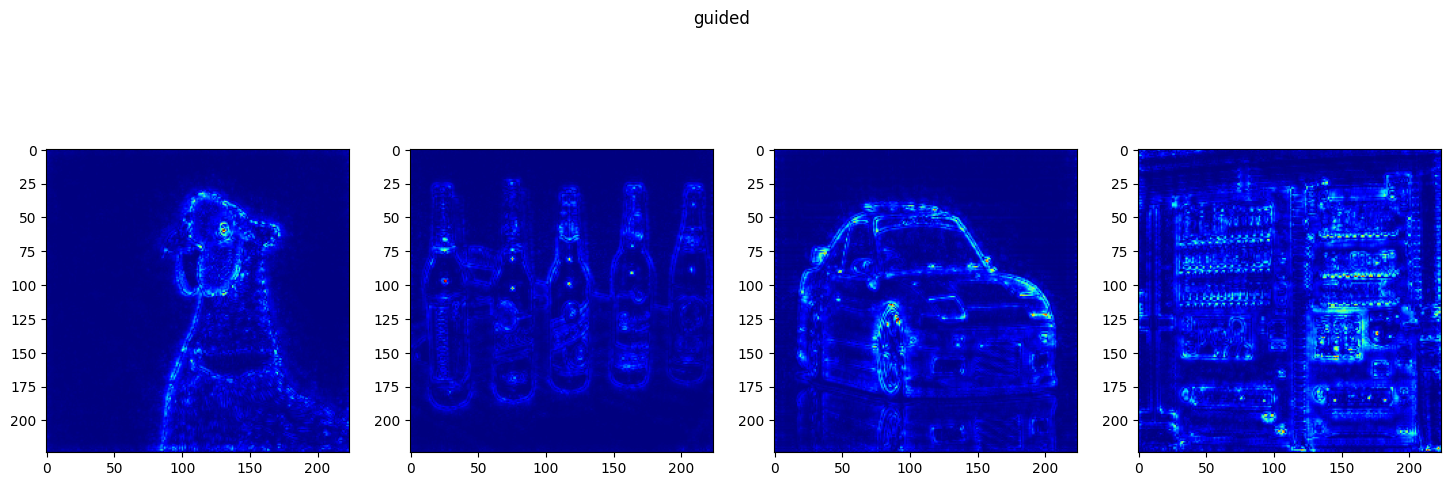

<Figure size 1800x600 with 0 Axes>

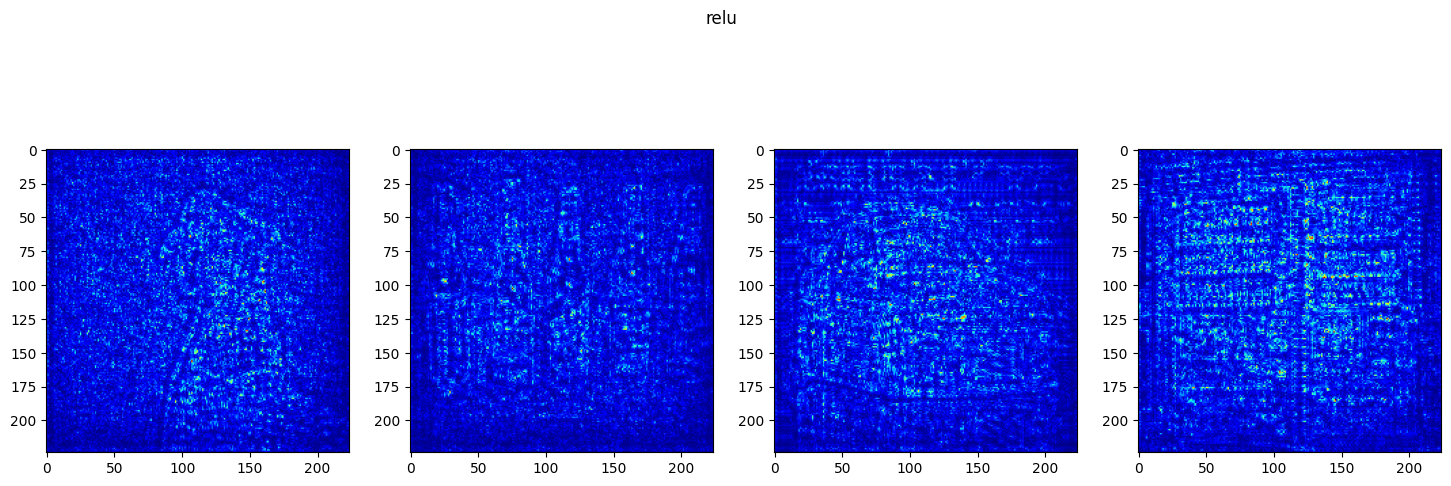

In [45]:
for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2, img3, img4]):    
        grads = visualize_saliency(model, layer_idx, filter_indices=INDICES[i], 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')

## Построение карт значимости классов

<Figure size 1800x600 with 0 Axes>

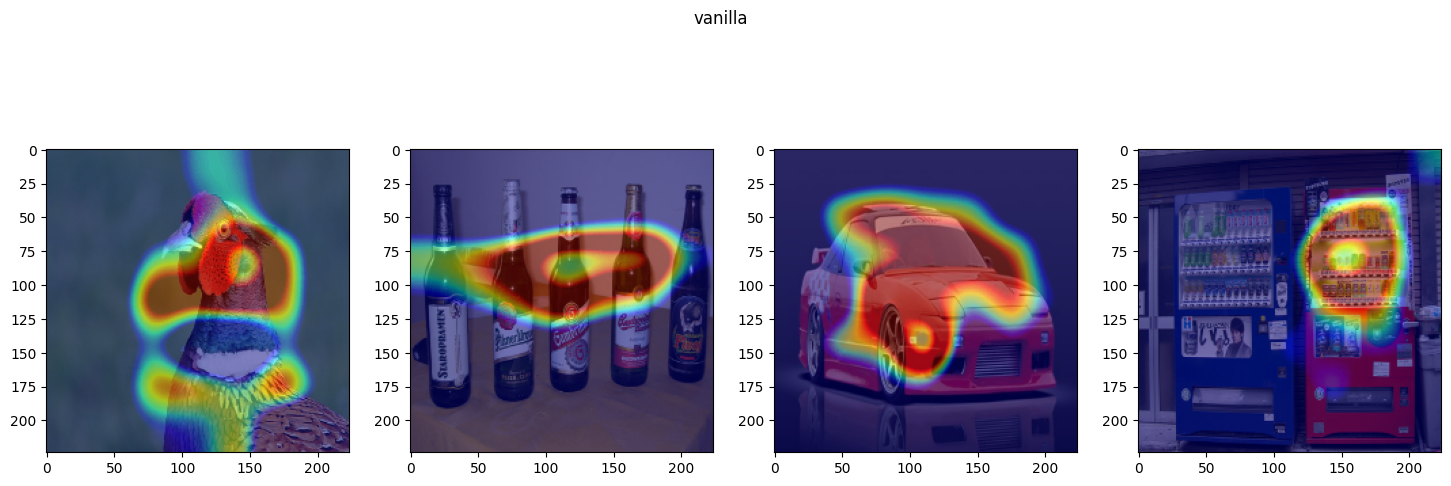

<Figure size 1800x600 with 0 Axes>

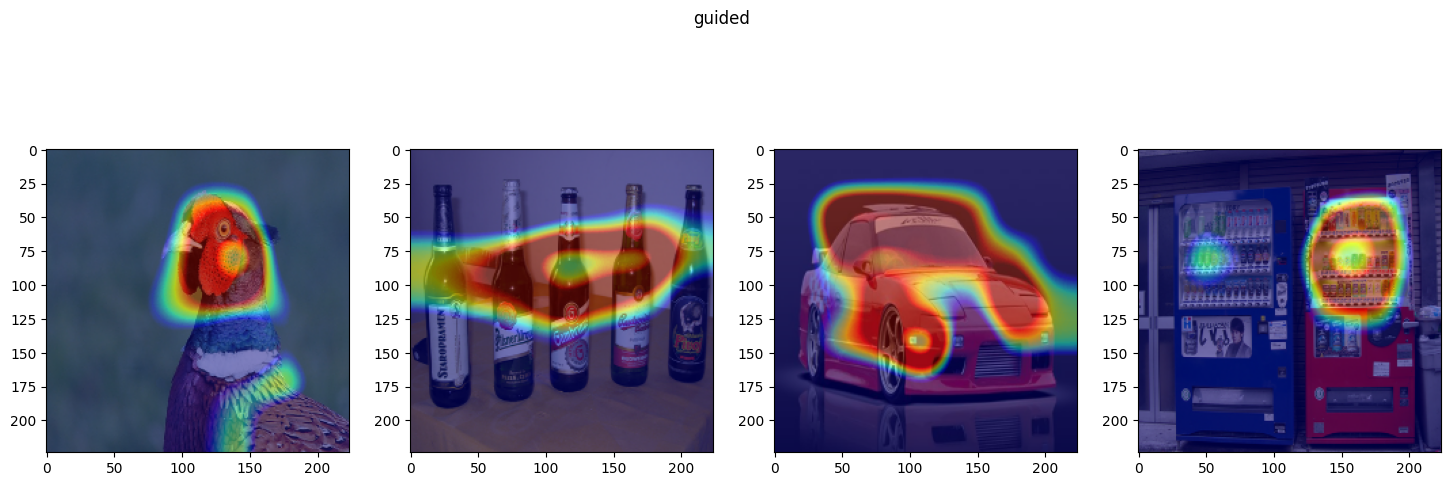

<Figure size 1800x600 with 0 Axes>

In [47]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 4)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2, img3, img4]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(model, layer_idx, filter_indices=INDICES[i], 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        
        jet_heatmap = jet_heatmap[:, :, 0, :]
        ax[i].imshow(overlay(jet_heatmap, img))

## Вывод

Наиболее точным методом описания активации слоёв нейронной сети является метод с управляемой важностью (`guided`).